### Applied Machine Learning 2b

##### Date: February 19 2020
##### Author: Jung Ah Shin 
##### Data source: https://www.kaggle.com/shree1992/housedata

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from category_encoders import TargetEncoder

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.model_selection import cross_val_score, GridSearchCV

In [ ]:
df = pd.read_csv('data.csv')
df.head()
df = df.drop(columns=['date','street','city','country']) #4600*17 columns
df.dtypes

price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
statezip          object
dtype: object

### 2.1 Determine which features are continuous vs categorical. Drop rows without a valid sales price

In [ ]:
#The categorical variables are as follows:
cat = ['bedrooms', 'bathrooms', 'floors','waterfront', 'view', 'condition', 'statezip'] #dropped city
#The continuous variables are as follows:
cont = ['sqft_living', 'sqft_lot','sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']  

#converting categorical column datatypes to object
for cols in cat:
    df[cols] = df[cols].astype(object)

df[['state','zipcode']] = df.statezip.str.split(expand=True)
df = df.drop(columns=['statezip'])


In [ ]:
#drop rows w/o valid sales price
df = df[df.price != 0.0] 
df.describe()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.551000e+03,4551.000000,4.551000e+03,4551.000000,4551.000000,4551.000000,4551.000000
mean,5.579059e+05,2132.372226,1.483528e+04,1822.221710,310.150516,1970.795649,808.564052
std,5.639299e+05,955.949708,3.596408e+04,854.452888,461.987629,29.760073,979.421487
min,7.800000e+03,370.000000,6.380000e+02,370.000000,0.000000,1900.000000,0.000000
25%,3.262643e+05,1460.000000,5.000000e+03,1190.000000,0.000000,1951.000000,0.000000
50%,4.650000e+05,1970.000000,7.680000e+03,1590.000000,0.000000,1976.000000,0.000000
75%,6.575000e+05,2610.000000,1.097800e+04,2300.000000,600.000000,1997.000000,1999.000000
max,2.659000e+07,13540.000000,1.074218e+06,9410.000000,4820.000000,2014.000000,2014.000000


### 2.2 Visualize the univariate distribution of each continuous feature, and the distribution of the target 

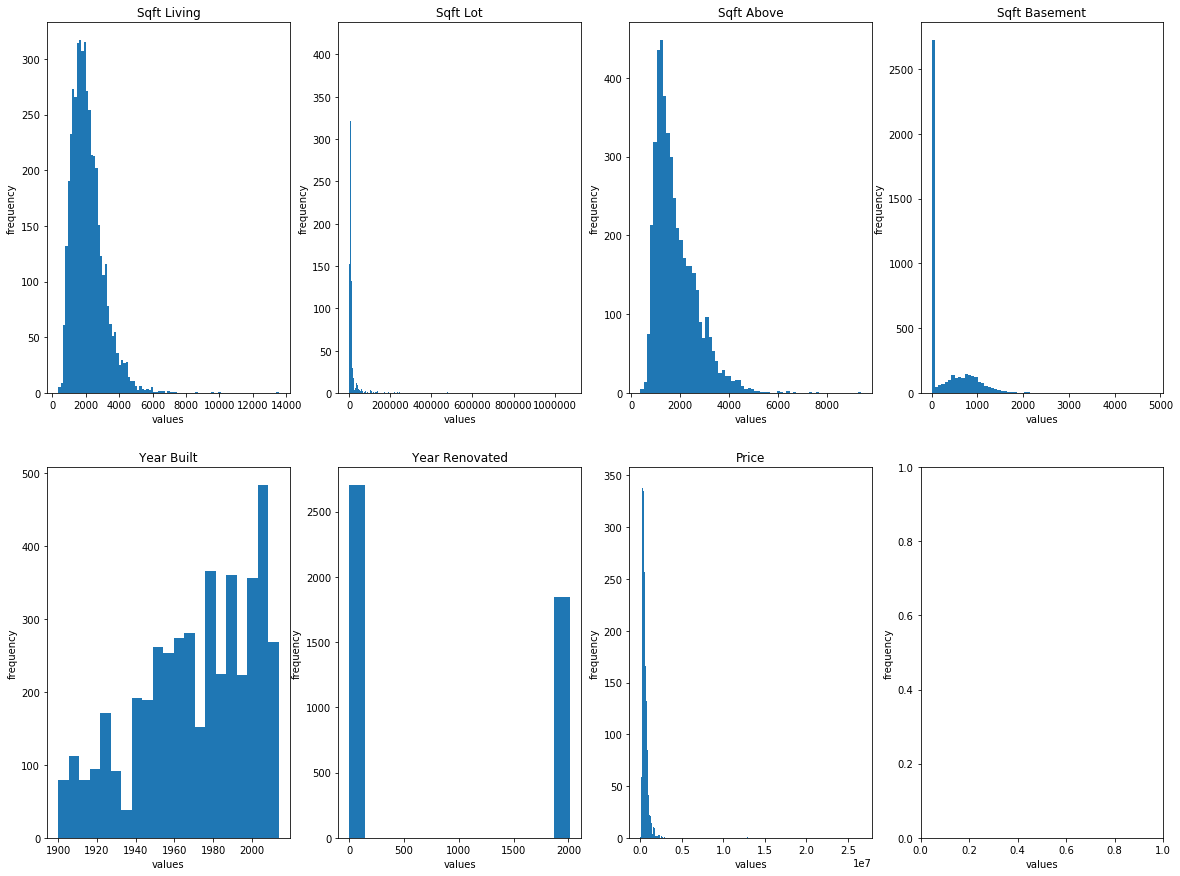

In [ ]:
# Plotting Continuous Features 
fig,ax = plt.subplots(2,4, figsize=(20,15))

ax[0,0].hist(df.sqft_living, bins='auto')
ax[0,1].hist(df.sqft_lot, bins='auto')
ax[0,2].hist(df.sqft_above, bins='auto')
ax[0,3].hist(df.sqft_basement, bins='auto')
ax[1,0].hist(df.yr_built, bins='auto')
ax[1,1].hist(df.yr_renovated, bins='auto')
ax[1,2].hist(df.price, bins='auto')

for i in range(2):
    for j in range(4):
        ax[i,j].set_ylabel('frequency')
        ax[i,j].set_xlabel('values')

ax[0,0].title.set_text('Sqft Living')
ax[0,1].title.set_text('Sqft Lot')
ax[0,2].title.set_text('Sqft Above')
ax[0,3].title.set_text('Sqft Basement')
ax[1,0].title.set_text('Year Built')
ax[1,1].title.set_text('Year Renovated')
ax[1,2].title.set_text('Price');

We can notice that all features tend to have various ranges in their values, so it would be more reasonable to scale these features to ensure all the variables are within the same range. Moreover, Sqft Living, Sqft Above, and other continuous variables tend to be skewed to the right. It is also interesting to note that the year renovated has two distinct concentrations in terms of the values(mostly 0s). 

### 2.3 Visualize the dependency of the target on each continuous feature (2d scatter plot)

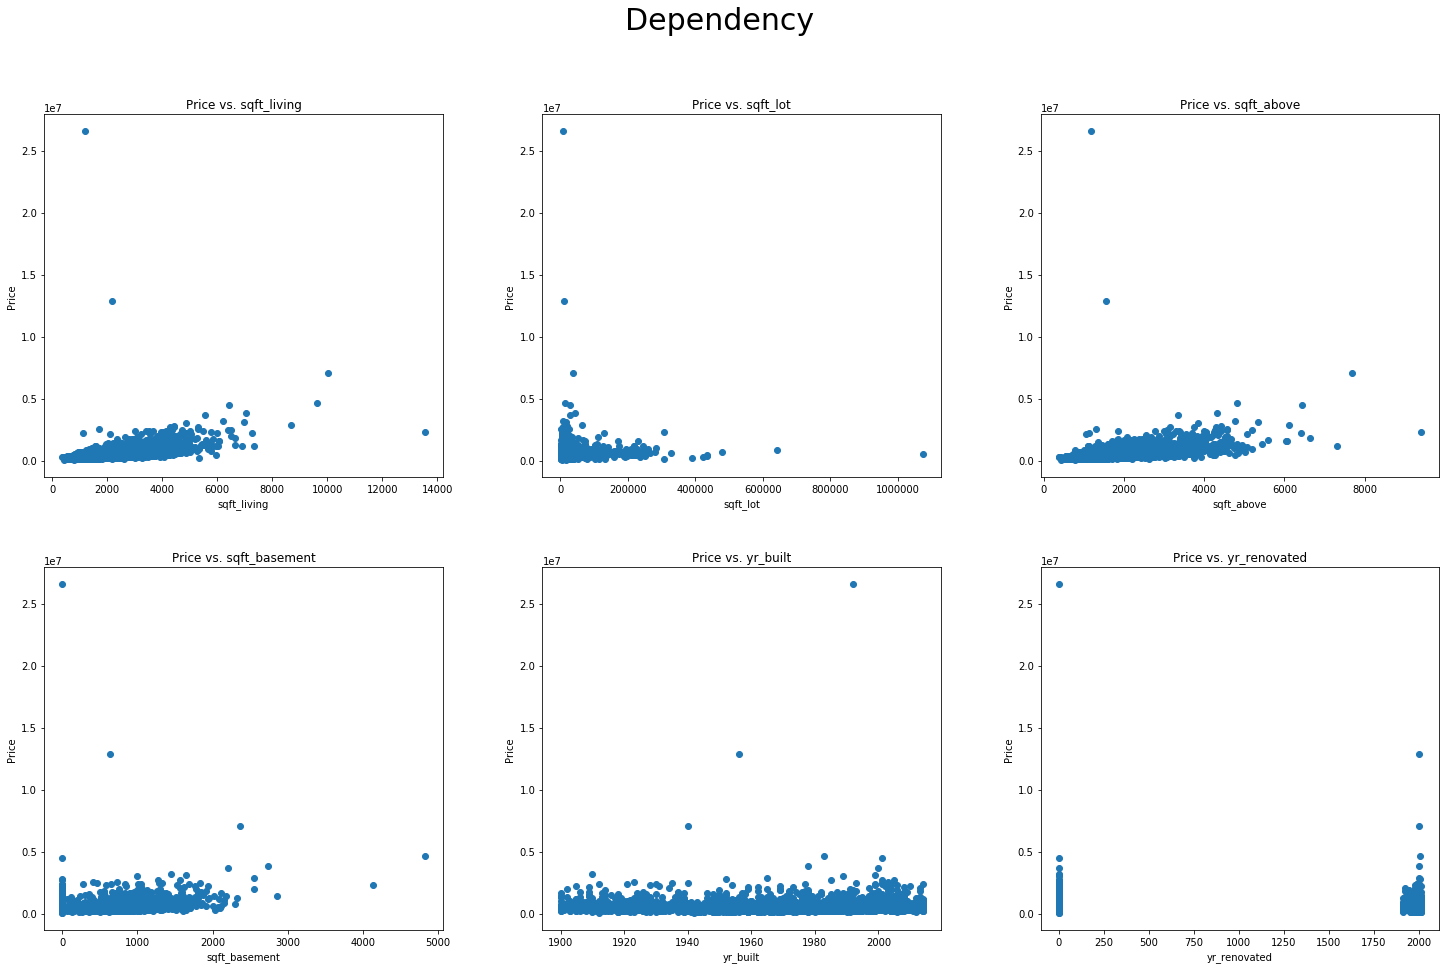

In [ ]:
width = 3
fig1,ax1 = plt.subplots(2,width, figsize=(25,15))
fig1.subplots_adjust(hspace=0.25, wspace=0.25)
fig1.suptitle("Dependency", fontsize=30)
for row in range(len(ax1)):
    for col in range(len(ax1[0])):
        i = width*row + col
        ax1[row, col].scatter(df[cont[i]], df['price'])
        ax1[row, col].title.set_text('Price vs. '+ cont[i])
        ax1[row, col].set_xlabel(cont[i])
        ax1[row, col].set_ylabel('Price')

### 2.4 Split data in training and test. Use ColumnTransformer and pipeline to encode categorical variables. Impute missing values using SimpleImputer. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default parameters.


In [ ]:
# Split data in training and test
X = df.iloc[:, 1:]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

#Use ColumnTransformer and pipeline (WITH STANDARD SCALER)
categorical = X_train.dtypes == 'object'

preprocess = make_column_transformer(
(SimpleImputer(strategy='mean'), ~categorical),
(StandardScaler(), ~categorical),
(OneHotEncoder(handle_unknown='ignore'), categorical))

# Evaluate OLS, Ridge, Lasso, and ElasticNet using cross-validation with default parameters

#Linear Regression
ols_model = make_pipeline(TargetEncoder(cols='zipcode'),preprocess, LinearRegression())
ols_scores = np.mean(cross_val_score(ols_model, X_train, y_train))

#Ridge Regression
ridge_model = make_pipeline(TargetEncoder(cols='zipcode'),preprocess, Ridge())
ridge_scores = np.mean(cross_val_score(ridge_model, X_train, y_train))

#Lasso Regression
lasso_model = make_pipeline(TargetEncoder(cols='zipcode'),preprocess, Lasso())
lasso_scores = np.mean(cross_val_score(lasso_model, X_train, y_train))

#ElasticNet 
elastic_model = make_pipeline(TargetEncoder(cols='zipcode'),preprocess, ElasticNet())
elastic_scores = np.mean(cross_val_score(elastic_model, X_train, y_train))


print(" Linear Regression: ", "{0:.3f}".format(np.mean(ols_scores)), "\n", 
      "Ridge Regression: ", "{0:.3f}".format(np.mean(ridge_scores)), "\n"
     ,"Lasso Regression: ", "{0:.3f}".format(np.mean(lasso_scores)), "\n",
      "ElasticNet: ", "{0:.3f}".format(np.mean(elastic_scores))
     )
                       

 Linear Regression:  0.464 
 Ridge Regression:  0.364 
 Lasso Regression:  0.463 
 ElasticNet:  0.378


In [ ]:
#Use ColumnTransformer and pipeline (WITH STANDARD SCALER)
categorical = X_train.dtypes == 'object'

preprocess1 = make_column_transformer(
(SimpleImputer(strategy='mean'), ~categorical),
(OneHotEncoder(handle_unknown='ignore'), categorical))

# Evaluate OLS, Ridge, Lasso, and ElasticNet using cross-validation with default parameters

#Linear Regression
ols_model = make_pipeline(TargetEncoder(cols='zipcode'),preprocess1, LinearRegression())
ols_scores = np.mean(cross_val_score(ols_model, X_train, y_train))

#Ridge Regression
ridge_model = make_pipeline(TargetEncoder(cols='zipcode'),preprocess1, Ridge())
ridge_scores = np.mean(cross_val_score(ridge_model, X_train, y_train))

#Lasso Regression
lasso_model = make_pipeline(TargetEncoder(cols='zipcode'),preprocess1, Lasso())
lasso_scores = np.mean(cross_val_score(lasso_model, X_train, y_train))

#ElasticNet 
elastic_model = make_pipeline(TargetEncoder(cols='zipcode'),preprocess1, ElasticNet())
elastic_scores = np.mean(cross_val_score(elastic_model, X_train, y_train))


print(" Linear Regression without StandardScaler: ", "{0:.3f}".format(np.mean(ols_scores)), "\n", 
      "Ridge Regression without StandardScaler: ", "{0:.3f}".format(np.mean(ridge_scores)), "\n"
     ,"Lasso Regression without StandardScaler: ", "{0:.3f}".format(np.mean(lasso_scores)), "\n",
      "ElasticNet without StandardScaler: ", "{0:.3f}".format(np.mean(elastic_scores))
     )
                       

 Linear Regression without StandardScaler:  0.463 
 Ridge Regression without StandardScaler:  0.364 
 Lasso Regression without StandardScaler:  0.463 
 ElasticNet without StandardScaler:  0.378


In terms of using StandardScaler or not, the mean score seem to remain the same and are not affected so much by scaling.

### 2.5 Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.

In [ ]:
pipe = Pipeline([('scaler', preprocess),
                ('regressor',LinearRegression())]) #placeholder

param_grid = [
             {'regressor': [ElasticNet()],
             'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1]
            }] #'regressor__l1_ratio': [0.3, 0.5, 0.7, .9, 1]

grid = GridSearchCV(pipe, param_grid = param_grid, return_train_score=True)
grid.fit(X_train, y_train)


#grid.best_params_
results = grid.cv_results_
results_df = pd.DataFrame.from_dict(results)

#To tune l1 ratio and Ridge, Lasso, ElasticNet
param_grid2 = [
             {'regressor': [Ridge()], #closer to 0
             'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
              {'regressor': [Lasso()], #closer to 1
             'regressor__alpha': [0.3, 0.5, 0.7, .9, 1]},
             {'regressor': [ElasticNet(alpha=grid.best_params_['regressor__alpha'])],
             'regressor__l1_ratio': [0.3, 0.5, 0.7, 0.9, 1]
            }] 

grid2 = GridSearchCV(pipe, param_grid = param_grid2, return_train_score=True)
grid2.fit(X_train, y_train)
#grid2.score(X_test, y_test)

results2 = grid2.cv_results_
results2_df = pd.DataFrame.from_dict(results2)
#results2_df['mean_test_score']
results_df

grid2.best_params_

{'regressor': ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.7,
            max_iter=1000, normalize=False, positive=False, precompute=False,
            random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 'regressor__l1_ratio': 0.7}

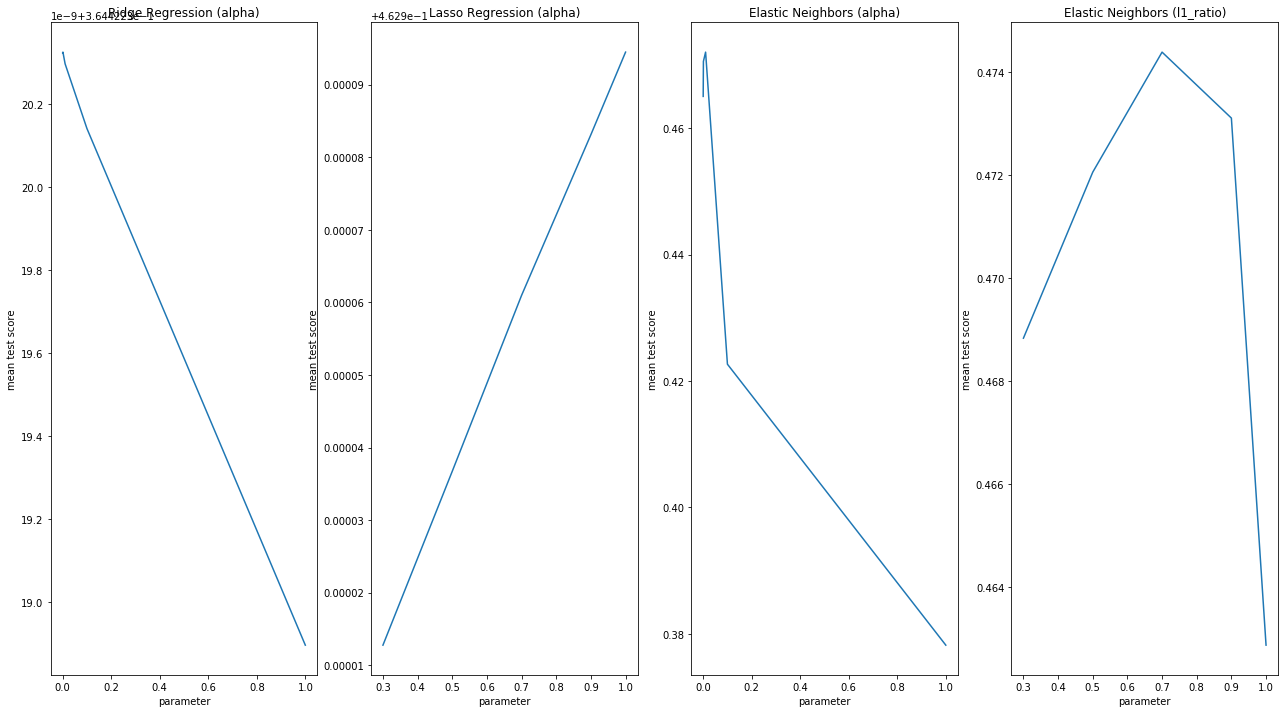

In [ ]:
#Visualize the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet
fig2, ax2 = plt.subplots(1,4, figsize=(22,12))

ax2[0].plot(results2_df.param_regressor__alpha[0:5], results2_df.mean_test_score[0:5])
ax2[1].plot(results2_df.param_regressor__alpha[5:10], results2_df.mean_test_score[5:10])
ax2[2].plot(results_df.param_regressor__alpha[0:5], results_df.mean_test_score[0:5])
ax2[3].plot(results2_df.param_regressor__l1_ratio[10:], results2_df.mean_test_score[10:]);


for i in range(4):
    ax2[i].set_xlabel('parameter')
    ax2[i].set_ylabel('mean test score')
    if i == 0:
        ax2[i].title.set_text('Ridge Regression (alpha)')
    elif i== 1:
        ax2[i].title.set_text('Lasso Regression (alpha)')
    elif i==2:
        ax2[i].title.set_text('Elastic Neighbors (alpha)')
    else:
        ax2[i].title.set_text('Elastic Neighbors (l1_ratio)')


In [ ]:
grid2.score(X_test, y_test)

0.691806003502299

Tuning the parameters using GridSearchCV has shown improved results, where the test score is 0.692. 

### 2.6 Visualize the 20 most important coefficients of the resulting models. Do they agree on which features are important?

In [ ]:
#Ridge
pipe_ridge = make_pipeline(preprocess, Ridge(alpha=grid.best_params_['regressor__alpha']))
pipe_ridge_model = pipe_ridge.fit(X_train, y_train)
pipe_ridge_coef = pipe_ridge_model[-1].coef_ #last model, and take coefficient
best_pipe_ridge_coef = np.argpartition(abs(pipe_ridge_coef), -20)[-20:]
print(best_pipe_ridge_coef)

#Lasso
pipe_lasso = make_pipeline(preprocess, Lasso(alpha=grid.best_params_['regressor__alpha']))
pipe_lasso_model = pipe_lasso.fit(X_train, y_train)
pipe_lasso_coef = pipe_lasso_model[-1].coef_ #last model, and take coefficient
best_pipe_lasso_coef = np.argpartition(abs(pipe_lasso_coef), -20)[-20:]
print(best_pipe_lasso_coef)

#Elastic 
pipe_elastic = make_pipeline(preprocess, ElasticNet(alpha=grid.best_params_['regressor__alpha'],l1_ratio=grid2.best_params_['regressor__l1_ratio']))
pipe_elastic_model = pipe_elastic.fit(X_train, y_train)
pipe_elastic_coef = pipe_elastic_model[-1].coef_ #last model, and take coefficient
best_pipe_elastic_coef = np.argpartition(abs(pipe_elastic_coef), -20)[-20:]
print(best_pipe_elastic_coef)



[ 50  51  25  14 137 116  66  45  61   3  46  59  27  15  13  10  52   2
   0   4]
[103  82 111  88  35 109  19 121 115 137 116  39  43  36  40  41  42  50
  87  66]
[ 64 134  99  63 108  65 136  36 115 111 121  76  82  50  51  88 137 116
  87  66]


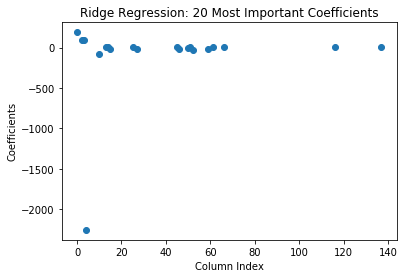

In [ ]:
#Ridge
ax = plt.scatter(best_pipe_ridge_coef, pipe_ridge_coef[best_pipe_ridge_coef])
plt.title('Ridge Regression: 20 Most Important Coefficients')
plt.ylabel('Coefficients')
plt.xlabel('Column Index');

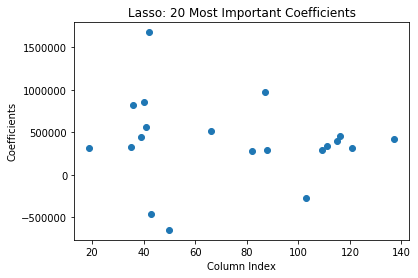

In [ ]:
#Lasso
ax = plt.scatter(best_pipe_lasso_coef, pipe_lasso_coef[best_pipe_lasso_coef])
plt.title('Lasso: 20 Most Important Coefficients')
plt.ylabel('Coefficients')
plt.xlabel('Column Index');

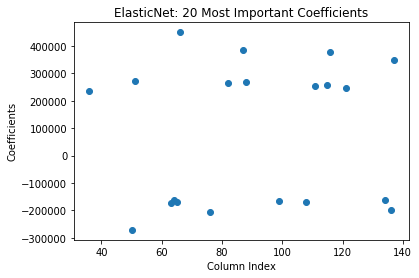

In [ ]:
#Elastic 
ax = plt.scatter(best_pipe_elastic_coef, pipe_elastic_coef[best_pipe_elastic_coef])
plt.title('ElasticNet: 20 Most Important Coefficients')
plt.ylabel('Coefficients')
plt.xlabel('Column Index');

The models differ in terms of which coefficients are most important. For Ridge Regression, most of the coefficients seem to have a small value, whereas ElasticNet has coefficients with varying magnitude from positive to negative. This is also the same for Lasso, although it is not as dispersed as ElasticNet.